In [3]:
# This code splits the given dataset to test-train files.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scienceplots
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import os

# Apply the default theme
#sns.set_theme()
#sns.set_style('white')
#sns.set_context("paper", font_scale = 2)
#plt.style.use(['science','no-latex'])
print('Pandas v', pd.__version__)

Pandas v 1.3.5


In [114]:
methods={}
methods['classic_ml'] = ['bow_nb', 'bow_xgboost', 'bow_svm', 'boc_nb', 'boc_xgboost', 'boc_svm',
       'tfidf_nb', 'tfidf_xgboost', 'tfidf_svm', 'tfidfng_nb',
       'tfidfng_xgboost', 'tfidfng_svm']
methods['hybrid'] = ['hybrid1_nb', 'hybrid1_xgboost',
       'hybrid1_svm', 'hybrid1_all_ml_averaged', 'hybrid2_boc',
       'hybrid2_tfidf', 'hybrid2_tfidf_ng', 'hybrid3', 'hybrid4_nb',
       'hybrid4_xgboost', 'hybrid4_svm']
methods['transformer'] = ['bert_en_uncased_L-12_H-768_A-12',
       'bert_en_cased_L-12_H-768_A-12',
       'small_bert/bert_en_uncased_L-2_H-128_A-2',
       'small_bert/bert_en_uncased_L-4_H-512_A-8',
       'small_bert/bert_en_uncased_L-8_H-128_A-2',
       'small_bert/bert_en_uncased_L-12_H-768_A-12',
       'bert_multi_cased_L-12_H-768_A-12', 'albert_en_base', 'electra_base',
       'electra_small']

In [4]:
# Notes about result files:
# 'results_230214_205321.pkl' # classical ML - Dataset: Train Kaggle, Test Kaggle
# 'results_230214_210527.pkl' # classical ML - Dataset: Train Harika, Test Harika
# 'results_230214_211201.pkl' # classical ML- Dataset: Train: Harika.train, Test: Kaggle.test

# 'results_230214_205100.pkl' # bert - Dataset: Train Kaggle, Test Kaggle
# '??.pkl' # bert- Dataset: Train Harika, Test Harika
# 'results_230214_193603.pkl' # bert- Dataset: Train: Harika.train, Test: Kaggle.test
main_folder = Path('../')


results_file = main_folder / 'results_230214_205321.pkl' # classical ML
results_file_bert = main_folder / 'results_230214_205100.pkl' # bert
print(results_file.is_file())
print(results_file_bert.is_file())

True
True


In [5]:

df = pd.read_pickle(results_file_bert)
#df

In [6]:
df = pd.read_pickle(results_file)
#df

In [7]:
#%%script echo skip
df = pd.read_pickle(results_file)
df2 = pd.read_pickle(results_file_bert)
df_all = pd.concat([df, df2])
#df_all
#df_all.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small","f1"]+1
#df_acc = (df_all.tn + df_all.tp).div(df_all.tn + df_all.tp + df_all.fn + df_all.fp)*100 #fill the missing accuracies that I forgot to record

#df_all.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small","overall_accuracy"] = df_acc.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small"]
#df_acc.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small"]

#df = df_all
#df

In [8]:
df = df_all.copy()

In [9]:
# Fix Nan value of hybrid1_all_ml_averaged

#df.loc["hybrid1_all_ml_averaged"]["training time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["training time"]
#df.loc["hybrid1_all_ml_averaged"]["testing time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["testing time"]
df.at["hybrid1_all_ml_averaged", "training time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["training time"]
df.at["hybrid1_all_ml_averaged", "testing time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["testing time"]
#df

In [10]:
# Normalize time (per sample/ms )
df.loc[:,"training time"] = df.loc[:,"training time"]*1000 / df.loc[:,"train size"]
df.loc[:,"testing time"] = df.loc[:,"testing time"]*1000 / df.loc[:,"test size"]

In [277]:
#df['log(f1/s)'] = np.log10(df.loc[:,"f1"] / df.loc[:,"testing time"])

In [245]:
df

,overall_accuracy,precision,recall,f1,tn,fp,fn,tp,train size,test size,train data,test data,training time,testing time,color,category
bow_nb,98.513558,0.978317,0.982151,0.980230,3775.0,50.0,41.0,2256.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.000774,0.000326,"[[0.7155247981545559, 0.8041061130334486, 0.88...",classic_ml
bow_xgboost,98.448220,0.996841,0.961689,0.978950,3818.0,7.0,88.0,2209.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.144264,0.004694,"[[0.764244521337947, 0.8389850057670126, 0.908...",classic_ml
bow_svm,98.546227,0.995067,0.966043,0.980340,3814.0,11.0,78.0,2219.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,2.012650,0.297275,"[[0.6708650519031142, 0.7729796232218378, 0.87...",classic_ml
boc_nb,92.045083,0.834442,0.983021,0.902658,3377.0,448.0,39.0,2258.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.000815,0.000815,"[[0.8978854286812764, 0.9390234525182622, 0.96...",classic_ml
boc_xgboost,99.673309,0.999123,0.992164,0.995631,3823.0,2.0,18.0,2279.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.360882,0.005050,"[[0.5490196078431373, 0.5750096116878124, 0.77...",classic_ml
boc_svm,99.640640,0.997376,0.993034,0.995201,3819.0,6.0,16.0,2281.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.421575,0.276956,"[[0.5700576701268744, 0.6326489811610919, 0.79...",classic_ml
tfidf_nb,97.141457,0.969469,0.953853,0.961598,3756.0,69.0,106.0,2191.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.000285,0.000163,"[[0.812964244521338, 0.8758938869665513, 0.929...",classic_ml
tfidf_xgboost,99.232277,0.999113,0.980409,0.989673,3823.0,2.0,45.0,2252.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.130031,0.002792,"[[0.5944175317185698, 0.6840753556324491, 0.82...",classic_ml
tfidf_svm,98.546227,0.988928,0.972138,0.980461,3800.0,25.0,64.0,2233.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,1.403676,0.252273,"[[0.6221453287197232, 0.7390234525182623, 0.85...",classic_ml
tfidfng_nb,92.273767,0.837029,0.986069,0.905457,3384.0,441.0,32.0,2265.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.000774,0.000494,"[[0.8576239907727797, 0.9097270280661285, 0.94...",classic_ml


In [237]:
for method in methods:
    df.loc[methods[method], 'category'] = method

In [244]:
# set the colormap for each category (classical ml, hybrid, transformer)
metric='f1'
method_categories = [i for i in methods.keys()]
method_cat_cm_func = [plt.cm.BuPu, plt.cm.YlGn, plt.cm.OrRd]
for k, cat in enumerate(method_categories):
    cat_cm_func = method_cat_cm_func[k]
    df_small = df[df['category']==cat] # OR df.loc[methods[cat]]
    
    df_small = df_small.sort_values(metric,ascending=False)
    col_names = df_small.columns
    row_names = df_small.index

    colors = cat_cm_func(np.linspace(0.1, 0.6, len(row_names)))
    colors = colors[::-1]
    df_small.loc[:, 'color'] = [ 0 for i in range(len(row_names))]
    for i, row_name in enumerate(row_names):
        df_small.loc[row_name,'color'] = [[np.asarray(colors[i],dtype=float)]]
        #print(row_name, df_small.loc[row_name,'color'])
    df.update(df_small)

In [220]:
#fig, ax = plt.subplots(figsize=(5, 5))
def my_plot_bar(df_small, ax, metric='f1'):
    plt.rcParams['font.family'] = "Times New Roman"
    
    col_names = df_small.columns
    row_names = df_small.index
    
    colors = df_small.loc[:,'color'].values
    colors = [list(colors[i][0]) for i in range(len(colors))]

    bar_vals = df_small.loc[:][metric].values.tolist()
    bar_tics = df_small.loc[:][metric].index.tolist()
    bar_width = 0.9

    bar_container = ax.bar(x=bar_tics, height=bar_vals, width=bar_width, color=colors)
    #ax.tick_params(axis='x', rotation=70, ha="right")
    plt.setp(ax.get_xticklabels(), rotation=70, ha="right", rotation_mode="default")
    plt.setp(ax.get_xticklabels(),  va="center", rotation_mode="anchor")
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False)
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    #ax.set(ylim=(0.8, 1))




[(0.85, 1.0)]

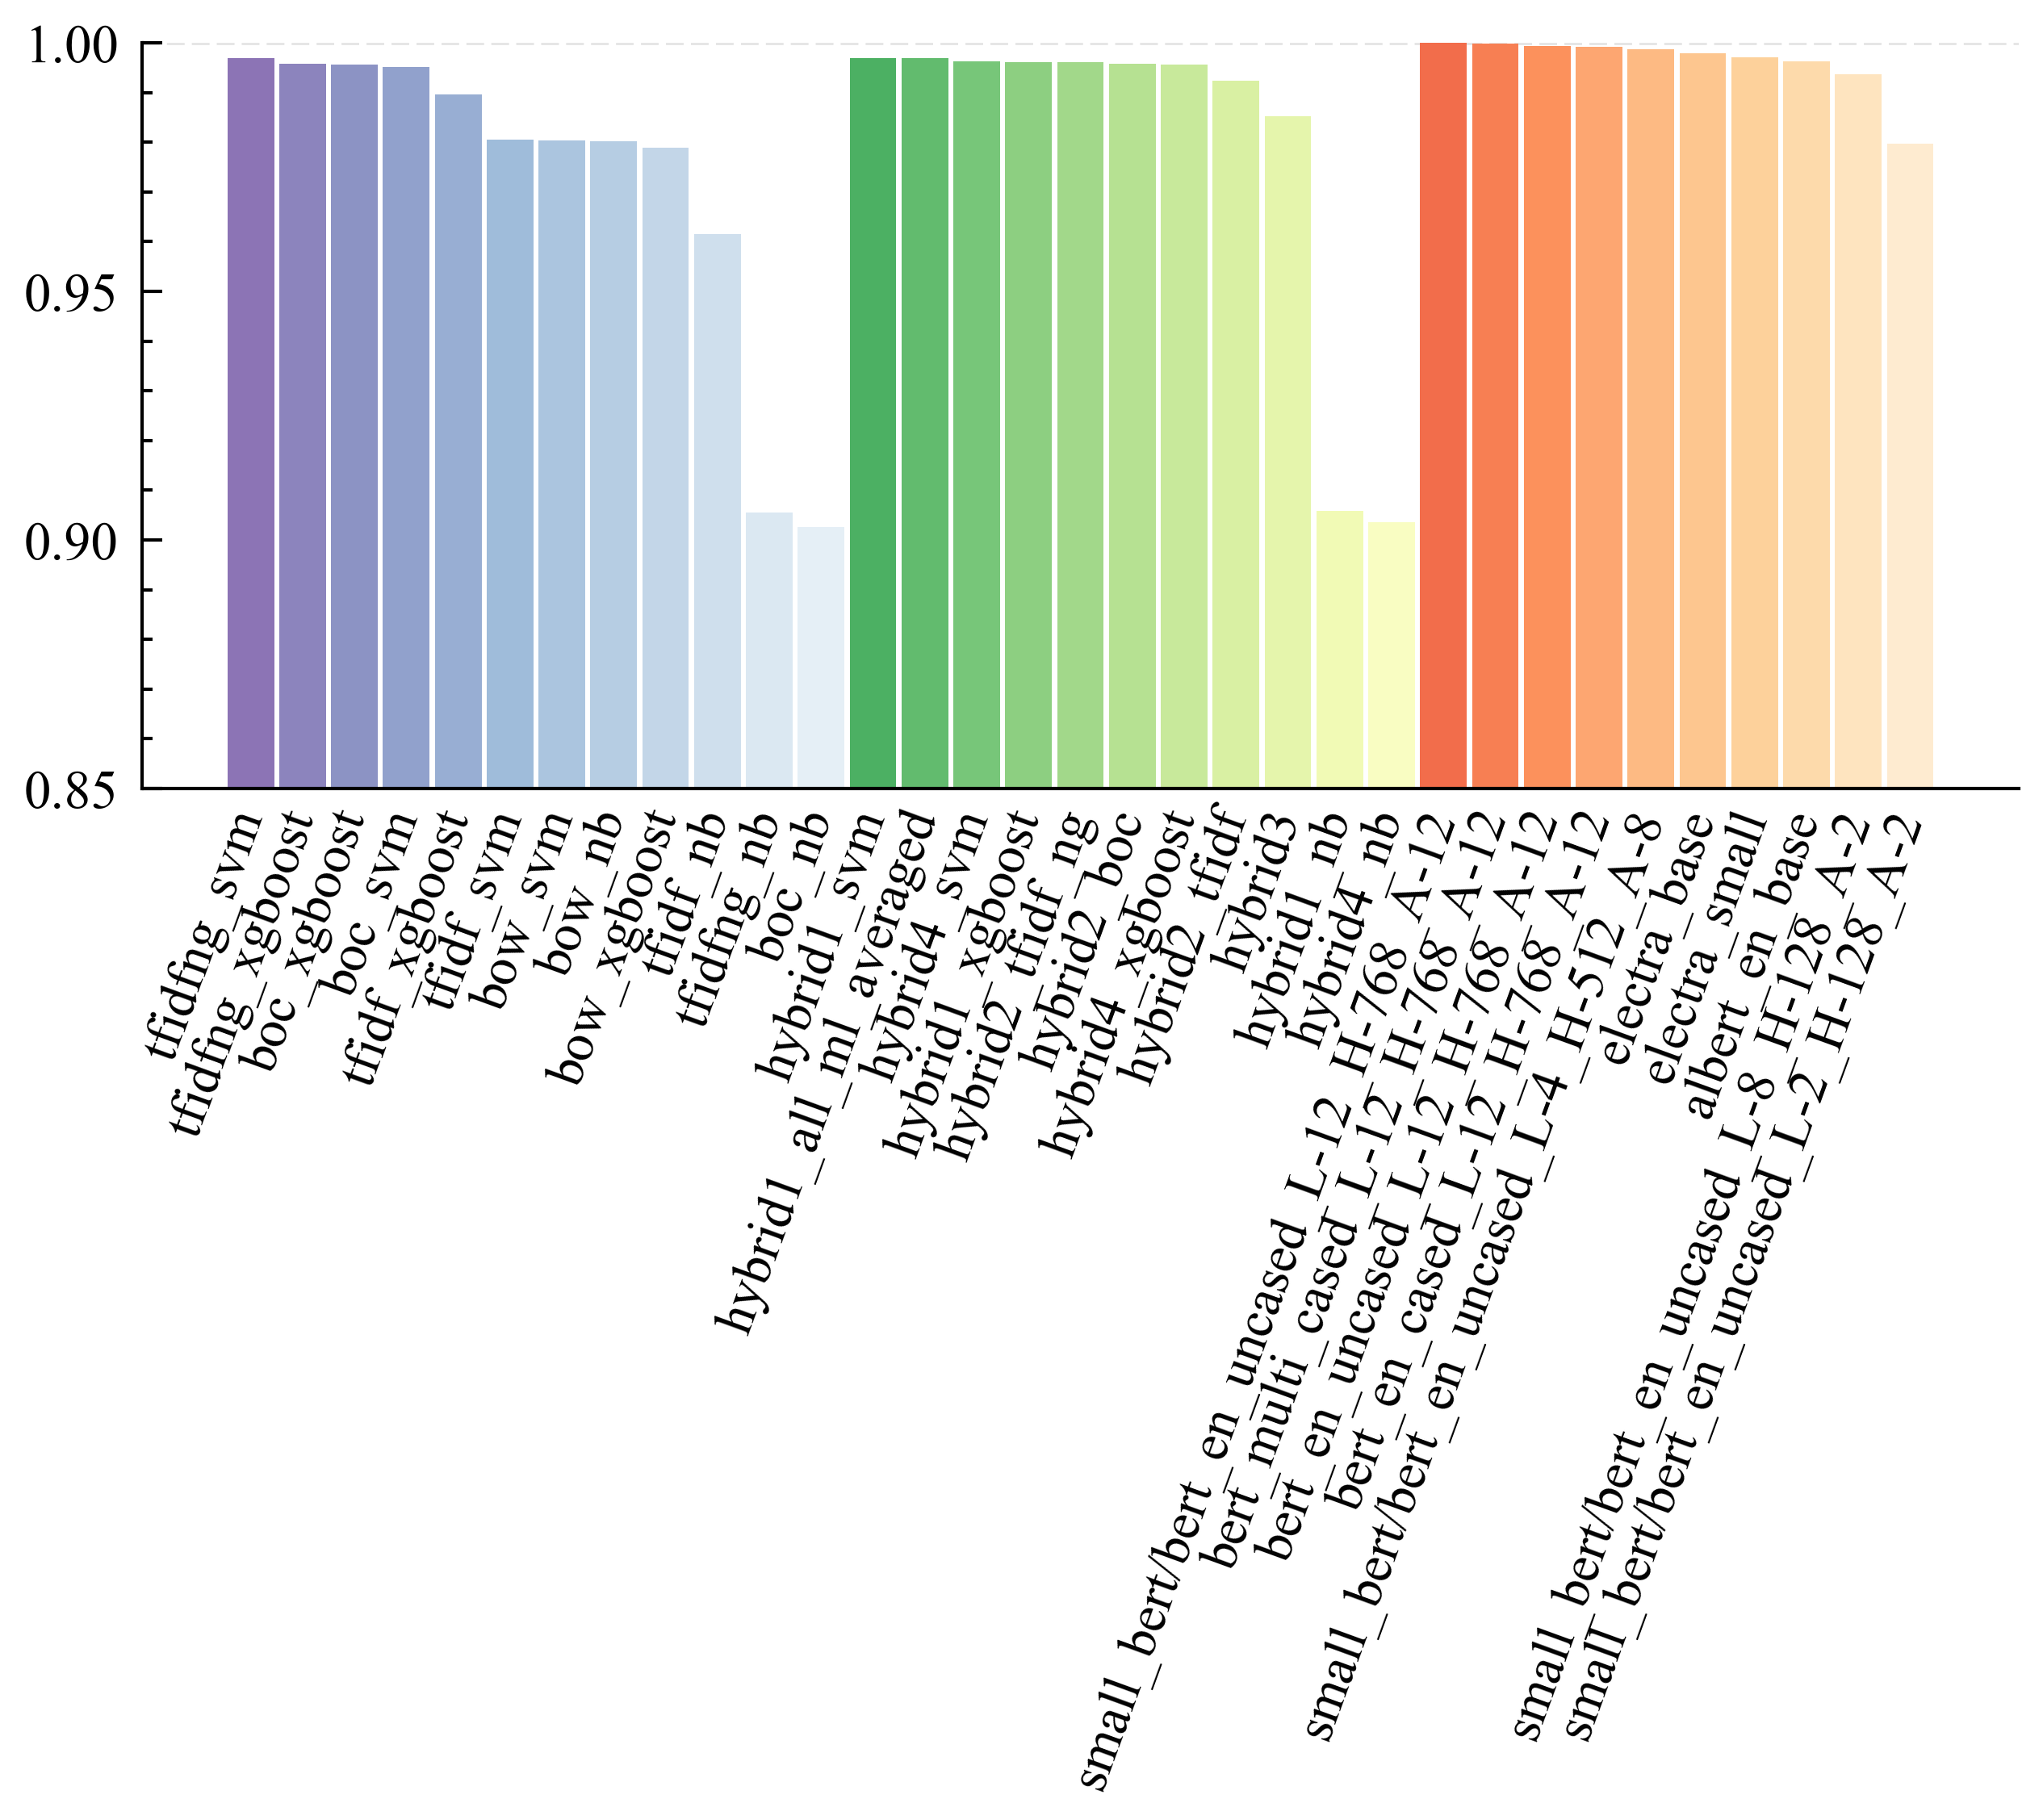

In [254]:
method_category = 'transformer'
metrics = ['overall_accuracy', 'precision', 'recall', 'f1', 'training time',
       'testing time', 'color']

df_small = df.sort_values(['category','f1'],ascending=[True, False])
#df_small = df.loc[methods[method_category], metrics]
#df_small = df_small.sort_values(['category','f1'],ascending=[True, False])

fig, ax = plt.subplots(figsize=(5, 2))
my_plot_bar(df_small,ax,'f1')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.85, 1))

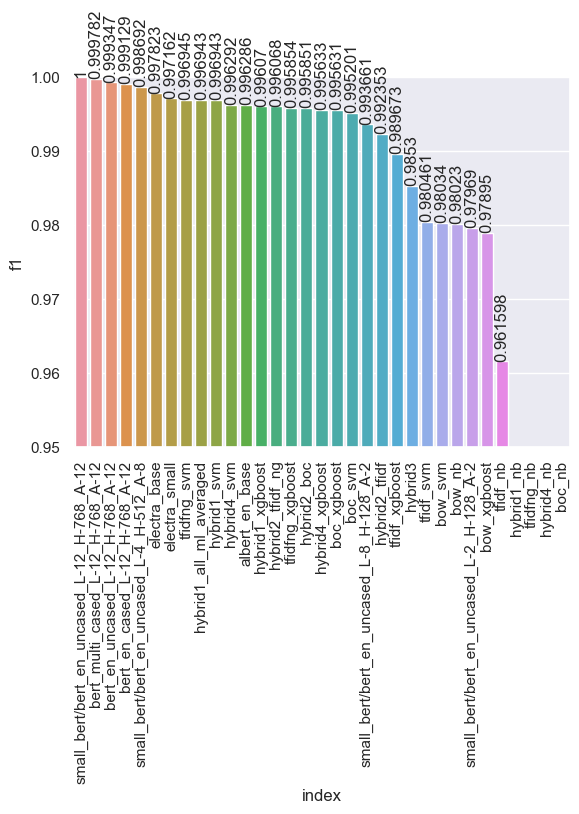

In [202]:
metric = 'f1'
df_sorted = df.sort_values(metric,ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="index", y=metric)
ax.tick_params(axis='x', rotation=90)
ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90)

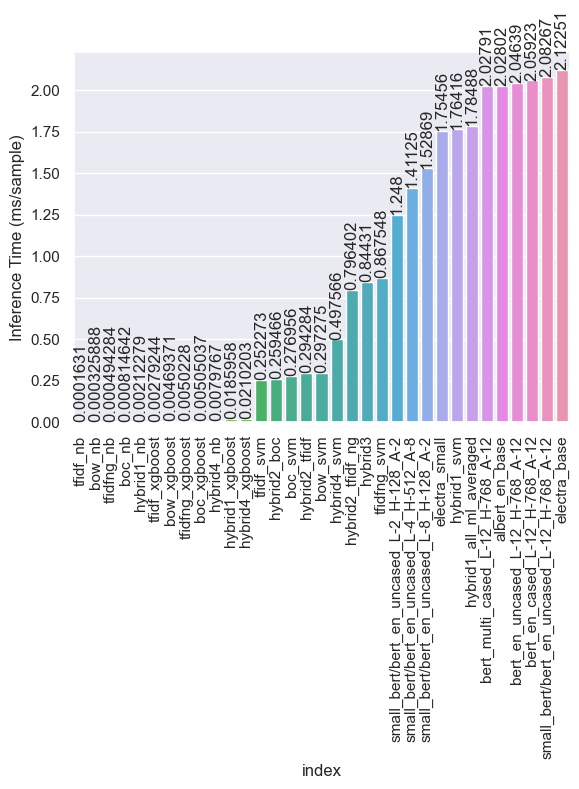

In [230]:
metric = 'testing time'
df_sorted = df.sort_values(metric,ascending=True).reset_index()
ax = sns.barplot(data=df_sorted,x="index", y=metric)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Inference Time (ms/sample)')
#ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90)

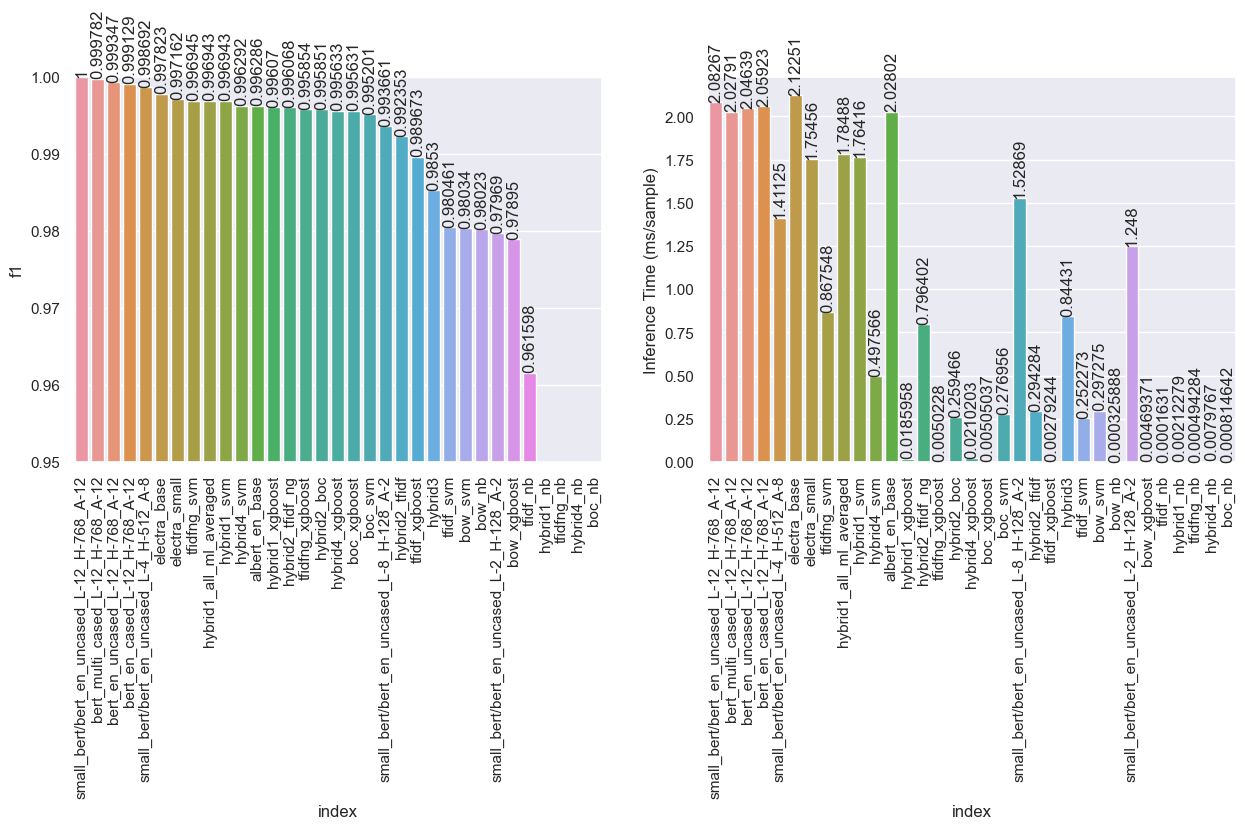

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

metric = 'f1'
df_sorted = df.sort_values(metric,ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="index", y=metric, ax=axes[0])
ax.tick_params(axis='x', rotation=90)
ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90)

metric = 'testing time'
#df_sorted = df.sort_values('f1',ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="index", y=metric, ax=axes[1])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Inference Time (ms/sample)')
#ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90)

In [ ]:
# experimental
df_sorted = df.sort_values("f1",ascending=False).reset_index()
df_res_index = df_sorted.reset_index()
df_melted = pd.melt(df_res_index, id_vars="index", var_name="metric", value_name="value")
#df_melted

# Latex

In [279]:
# Rename Columns and Index properly (for latex tables and figures)
def rename_table_labels(df_bad_labeled):
    column_mapper = {
        "overall_accuracy": "Accuracy", 
        "precision": "Precision",
        "recall":"Recall",
        "f1":"F1",
        "tn":"TN",
        "tp":"TP",
        "fn":"FN",
        "fp":"FP",
        "train size":"Train Size",
        "test size":"Test Size",
        "train data":"Train Data",
        "test data":"Test Data",
        "training time":"Training Time (ms)",
        "testing time":"Inference Time (ms)",
        "log(f1/s)":"F1 Efficiency"
        }
    index_mapper = {
        "bow_nb": "BoW NB",
        "bow_xgboost": "BoW XGBoost", #TODO rename all
        'bow_svm':'BoW SVM',
        'boc_nb': 'BoC NB', 
        'boc_xgboost':'BoC XGBoost', 
        'boc_svm': 'BoC SVM',
        'tfidf_nb': 'TF-IDF NB', 
        'tfidf_xgboost': 'TF-IDF XGBoost', 
        'tfidf_svm': 'TF-IDF SVM', 
        'tfidfng_nb': 'TF-IDF ngram NB',
        'tfidfng_xgboost': 'TF-IDF ngram XGBoost', 
        'tfidfng_svm': 'TF-IDF ngram SVM', 
        'hybrid1_nb': 'Hybrid-1 NB', 
        'hybrid1_xgboost': 'Hybrid-1 XGBoost',
        'hybrid1_svm': 'Hybrid-1 SVM', 
        'hybrid1_all_ml_averaged': 'Hybrid-1 All', 
        'hybrid2_boc': 'Hybrid-2 BoC',
        'hybrid2_tfidf': 'Hybrid-2 TF-IDF', 
        'hybrid2_tfidf_ng': 'Hybrid-2 TF-IDF ngram', 
        'hybrid3': 'Hybrid-3', 
        'hybrid4_nb': 'Hybrid-4 NB',
        'hybrid4_xgboost': 'Hybrid-4 XGBoost', 
        'hybrid4_svm': 'Hybrid-4 SVM'#, 
        # 'bert_en_uncased_L-12_H-768_A-12',
        # 'bert_en_cased_L-12_H-768_A-12',
        # 'small_bert/bert_en_uncased_L-2_H-128_A-2',
        # 'small_bert/bert_en_uncased_L-4_H-512_A-8',
        # 'small_bert/bert_en_uncased_L-8_H-128_A-2',
        # 'small_bert/bert_en_uncased_L-12_H-768_A-12',
        # 'bert_multi_cased_L-12_H-768_A-12', 'albert_en_base', 'electra_base',
        # 'electra_small'
    }
    
    df_new_labeled = df_bad_labeled.rename(columns=column_mapper, index=index_mapper)
    df_new_labeled.index.rename("Method",inplace=True)
    return df_new_labeled

## Latex Figures

In [300]:
import scienceplots
plt.style.use(['science','no-latex','ieee'])

## Latex tables

In [329]:
import pathlib
latex_dir = Path(r"C:\Users\3057550\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal")
table_folder= latex_dir / "Tables"
figure_folder= latex_dir / "Figures"
assert (table_folder.is_dir()), "No such folder"
assert (figure_folder.is_dir()), "No such folder"



In [259]:
def process_style_to_my_latex_format(df_latex):
    # returns style object
    s = df_latex.reset_index().style.hide_index()
    s = s.format(precision=4, escape="latex")
    return s

In [281]:
%%script echo skipping cell
# template
table_name = "small"
caption="Generated by python"
out_file_name = (table_folder / table_name).with_suffix('.tex') 

df_small = df.loc["bow_nb":"bow_svm",["f1","tp"]]

df_small = rename_table_labels(df_small)
#print(df_small)

s = process_style_to_my_latex_format(df_small)
#df_small.style.columns[1:]
# s.to_latex(buf=out_file_name,
#     column_format="l|rr", position="ht", position_float="centering",
#     hrules=True, label=f"tab:{table_name}", caption=caption)

# print(s.to_latex(
#     column_format="l|rr", position="ht", position_float="centering",
#     hrules=True, label=f"table:{table_name}", caption=caption)
# )


Couldn't find program: 'echo'


In [309]:
# Table: Single NLP
table_name = "single"
caption="Accuracy and inference speed of single NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
methods = ['bow_nb', 'bow_xgboost', 'bow_svm', 'boc_nb', 'boc_xgboost', 'boc_svm',
       'tfidf_nb', 'tfidf_xgboost', 'tfidf_svm', 'tfidfng_nb',
       'tfidfng_xgboost', 'tfidfng_svm']
metrics = ['overall_accuracy', 'precision', 'recall', 'f1', 'training time',
       'testing time']

df_small = df.loc[methods, metrics]

df_small = rename_table_labels(df_small)
#print(df_small)

s = process_style_to_my_latex_format(df_small)

s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

s.to_latex(buf=out_file_name,
    column_format="lrrrrrr", position="htbp", position_float="centering",
    hrules=True, label=f"tab:{table_name}", caption=caption)

# print(s.to_latex(
#     column_format="lrrrrrr", position="ht", position_float="centering",
#     hrules=True, label=f"table:{table_name}", caption=caption)
# )
#df.loc[:,"training time"] / df.loc[:,"train size"]
#(df.loc[:,["training time", "testing time"]]*1000).div(df.loc[:,["train size", "test size"]])

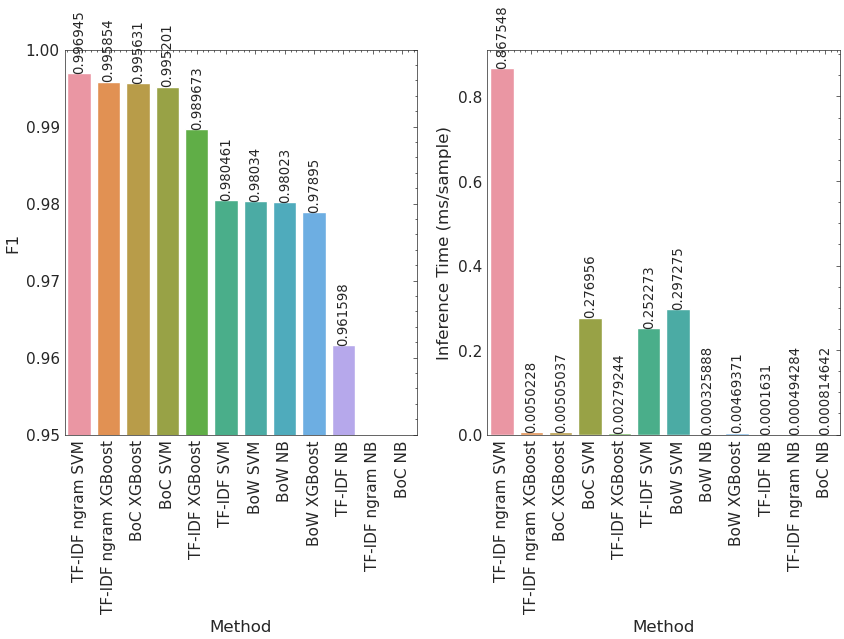

In [332]:
# Figure of Table Single NLP
current_figure_name = 'single_nlp_f1_vs_time.png'
plt.style.use(['science','no-latex','ieee'])
plt.rcParams.update({'figure.dpi': '100'})
fig, axes = plt.subplots(1, 2, figsize=(10,5))

metric = 'F1'
df_sorted = df_small.sort_values(metric,ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="Method", y=metric, ax=axes[0])
ax.tick_params(axis='x', rotation=90)
ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90, fontsize='large')

metric = 'Inference Time (ms)'
#df_sorted = df.sort_values('f1',ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="Method", y=metric, ax=axes[1])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Inference Time (ms/sample)')
#ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90,fontsize='large')

ax.get_figure().savefig(figure_folder / current_figure_name)


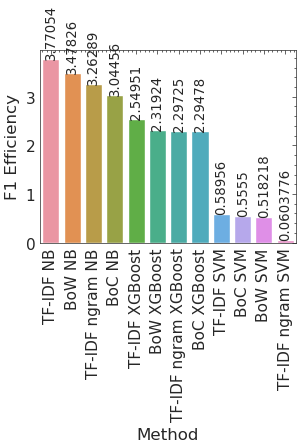

In [334]:
# Figure of Table Single NLP - F1 Efficiency metric is 
#fig, axes = plt.subplots(1, 1, figsize=(10,5))
current_figure_name = 'single_nlp_f1_efficiency.png'
plt.style.use(['science','no-latex','ieee'])
plt.rcParams.update({'figure.dpi': '100'})
metrics = ['log(f1/s)']
df_small = df.loc[methods, metrics]
df_small = rename_table_labels(df_small)

metric = 'F1 Efficiency'
df_sorted = df_small.sort_values(metric,ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="Method", y=metric)
ax.tick_params(axis='x', rotation=90)
#ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90,fontsize='large')

ax.get_figure().savefig(figure_folder / current_figure_name)

                       f1  testing time  inference scaled        EF
bow_nb           0.980230      0.000326          0.999812  0.980230
bow_xgboost      0.978950      0.004694          0.994777  0.978950
bow_svm          0.980340      0.297275          0.657462  0.980340
boc_nb           0.902658      0.000815          0.999249  0.902658
boc_xgboost      0.995631      0.005050          0.994366  0.995631
boc_svm          0.995201      0.276956          0.680888  0.995201
tfidf_nb         0.961598      0.000163          1.000000  0.961598
tfidf_xgboost    0.989673      0.002792          0.996969  0.989673
tfidf_svm        0.980461      0.252273          0.709345  0.980461
tfidfng_nb       0.905457      0.000494          0.999618  0.905457
tfidfng_xgboost  0.995854      0.005023          0.994397  0.995854
tfidfng_svm      0.996945      0.867548          0.000000  0.996945


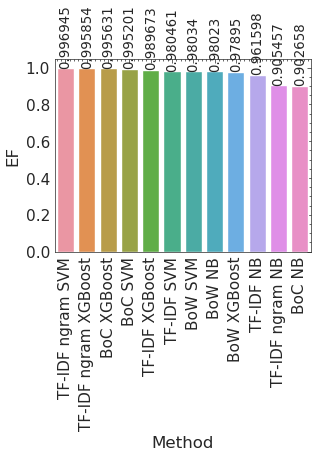

In [363]:
from sklearn import preprocessing
metrics = ['f1','testing time']
df_small = df.loc[methods, metrics]

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(1.0000 - df_small['testing time'].to_numpy().reshape(-1, 1))
df_small['inference scaled'] = x_scaled
alpha=1.00 #emphasis on F1 rather than speed
df_small['EF'] = alpha*df_small['f1'] + (1-alpha)*df_small['inference scaled']
print(df_small)

current_figure_name = 'single_nlp_ef_alpha50.png'
plt.style.use(['science','no-latex','ieee'])
plt.rcParams.update({'figure.dpi': '100'})
df_small = rename_table_labels(df_small)

metric = 'EF'
df_sorted = df_small.sort_values(metric,ascending=False).reset_index()
ax = sns.barplot(data=df_sorted,x="Method", y=metric)
ax.tick_params(axis='x', rotation=90)
#ax.set(ylim=(0.95, 1))
for i in ax.containers:
    ax.bar_label(i,rotation=90,fontsize='large')

#ax.get_figure().savefig(figure_folder / current_figure_name)

In [180]:
print(df.index)
print(df.columns)

Index(['bow_nb', 'bow_xgboost', 'bow_svm', 'boc_nb', 'boc_xgboost', 'boc_svm',
       'tfidf_nb', 'tfidf_xgboost', 'tfidf_svm', 'tfidfng_nb',
       'tfidfng_xgboost', 'tfidfng_svm', 'hybrid1_nb', 'hybrid1_xgboost',
       'hybrid1_svm', 'hybrid1_all_ml_averaged', 'hybrid2_boc',
       'hybrid2_tfidf', 'hybrid2_tfidf_ng', 'hybrid3', 'hybrid4_nb',
       'hybrid4_xgboost', 'hybrid4_svm', 'bert_en_uncased_L-12_H-768_A-12',
       'bert_en_cased_L-12_H-768_A-12',
       'small_bert/bert_en_uncased_L-2_H-128_A-2',
       'small_bert/bert_en_uncased_L-4_H-512_A-8',
       'small_bert/bert_en_uncased_L-8_H-128_A-2',
       'small_bert/bert_en_uncased_L-12_H-768_A-12',
       'bert_multi_cased_L-12_H-768_A-12', 'albert_en_base', 'electra_base',
       'electra_small'],
      dtype='object')
Index(['overall_accuracy', 'precision', 'recall', 'f1', 'tn', 'fp', 'fn', 'tp',
       'train size', 'test size', 'train data', 'test data', 'training time',
       'testing time'],
      dtype='object')


End